<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rastertodataframe
!pip install pyproj
!pip install geopandas

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling

from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Model metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# User Defined Functions

In [3]:
# --FEATURE SELECTION--

#Filter photos (gaussian or median) from directory path
def filter_raws(path_to_dir,  sigma = 5, nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], filter_type = 'gaussian'):
    raw_files = list(os.listdir(path_to_dir))

    filter_df = pd.DataFrame()
    for i in raw_files[:]:
        raw_img = gdal.Open(os.path.join(path_to_dir, i))
        rows = raw_img.RasterYSize
        cols = raw_img.RasterXSize
        
        raw_array = np.array(raw_img.ReadAsArray())
        
        if filter_type == 'gaussian':
            raw_filter = gaussian_filter(raw_array, sigma = sigma)
        elif filter_type == 'median':
            raw_filter = median_filter(raw_array, size = 10)
        
        raw_filter = raw_filter.flatten()
        filter_df[i[index[0]:index[1]]] = raw_filter
    
    nrcan = gdal.Open(os.path.join(path_to_dir, '..', nrcan_name))
    nrcan_array = np.array(nrcan.ReadAsArray())
    
    filter_df['y'] = nrcan_array.flatten()
    return filter_df


def outlier_fix(dataframe):
    
    new_frame = pd.DataFrame()
    
    for column in dataframe.columns:
        
        #make sure we don't transform y column
        if column != 'Class':
            #create deepcopy to change
            temp_band = deepcopy(dataframe.loc[:,column].values)
            outlier = np.quantile(temp_band, q = 0.75) * 2
              
            #replace any above outlier with mean    
            temp_band[temp_band > outlier] = np.mean(temp_band)
            new_frame[f"{column}f"] = temp_band
    #if dataframe has a y column add back in    
    try:
        new_frame['Class'] = dataframe['Class']
        return new_frame
    #if not (ex: its X dataframe) just return frame
    except:
        return new_frame
        
def add_layers(df):
    """
    This function takes in a dataframe and calculates the NDVI, Moisture Index, NDWI and NDSI
    Outputs = dataframe with added layer columns 
    """
    #Create NDVI column (B08-B04)/(B08+B04)
    df['NDVI'] = (df.B08 - df.B04)/(df.B08 + df.B04)
    #Create Moisture index (B8A-B11)/(B8A+B11)
    df['Moisture'] = (df.B8A - df.B11)/(df.B8A + df.B11)
    #Create NDWI (B3-B8)/(B3+B8)
    df['NDWI'] = (df.B03 - df.B08)/(df.B03 + df.B08)
    #create NDSI (B3-B11)/(B3+B11)
    df['NDSI'] = (df.B03 - df.B11)/(df.B03 + df.B11)

   
    return df

#Calculated layers
def add_extra_layers(df):
    """
    This function takes in a dataframe and calculates an extra five layers
    Outputs = dataframe with added layer columns 
    """
     #normalized NIR/Blue normalized veg index
    df['NIRB'] = (df.B08 - df.B02)/(df.B08 + df.B02)
    #green normalized difference veg index
    df['NIRB'] = (df.B08 - df.B03)/(df.B08 + df.B03)
    #Atmospheric Resistant Green
    df['ARG'] = (df.B03 - df.B04)/(df.B03 + df.B04)
    # yellow veg index
    df['yellow'] = (0.723 * df.B03) - (0.597 * df.B04) + (0.206 * df.B06) - (0.278 * df.B09)
    #Mid-infrared veg index
    df['MIVI'] = df.B09/df.B11
    #GDVI
    df['GDVI'] = df.B08 - df.B03

    
def replace_values(df):
    """
    This function replaces the infinity values with Nan then replaces that with new infinity values
    """
    #Replace infinity values with Nan
    df.replace([np.inf, -np.inf], np.NAN, inplace=True)

    #Fill in null values
    df.fillna(999, inplace=True)

    return df

#--EVALUATION--
def get_scores(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: The scores and classification report for the model
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Print measure scores
  print(f"Accuracy: {accuracy_score(y, y_prediction)}")
  print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_prediction)}")
  print(f"F1 Score: {f1_score(y, y_prediction, average='micro')}")
  print(f"Precision Score: {precision_score(y, y_prediction, average='micro')}")
  print(f"Recall Score: {recall_score(y, y_prediction, average='micro')}")
  print(f"ROC AUC Score: {roc_auc_score(y, model.predict_proba(x),multi_class='ovr', average='macro')}")

  #print full classification report
  print(classification_report(y, y_prediction))

def create_class_matrix(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: A confusion matrix plot with all class labels
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Create a confusion matrix
  matrix = confusion_matrix(y, y_prediction)

  #Visualize the matrix with Seaborn

  #Write title to display accuracy score
  score = balanced_accuracy_score(y, y_prediction)
  all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

  #Set figure shape
  plt.figure(figsize=(9,9))

  #Use heatmap
  p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

  #Label the plot
  label = [0,1,2,5,6,8,10,11,12,13,14,15,16,17,18,19]
  p.set_ylabel('Actual Label', size=16)
  p.set_xlabel('Predicted Label', size = 16)
  p.set_xticklabels(label)
  p.set_yticklabels(label)
  p.set_title(all_sample_title, size = 18)

def print_importance(model, x):
    """
    Input: Model and X prior to split]
    Output: Series of feature importance coefficients in descending order
    """
    feature_importances = pd.DataFrame(model.feature_importances_, index = x.columns, columns = ['importance']).sort_values('importance', ascending = False)
    print(feature_importances)

# Download Data

In [4]:
#load raws into dataframe
version10 = pd.read_csv('/content/drive/MyDrive/AISC/version10.csv')

In [5]:
#Check number of pixels per class
version10.y.value_counts()

0     60000
1     60000
2     60000
5     60000
6     60000
8     60000
10    60000
11    60000
12    60000
13    60000
14    60000
15    60000
16    60000
17    60000
18    60000
19    47120
Name: y, dtype: int64

# Train Model - Version10

In [20]:
#split Data
y = version10.y
X = version10.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.90614962]


In [21]:
#Instantiate and Fit Model
rfc = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6501921615001267
Balanced Accuracy: 0.6521334624363327
F1 Score: 0.6501921615001267
Precision Score: 0.6501921615001267
Recall Score: 0.6501921615001267
ROC AUC Score: 0.9570604667512439
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12000
           1       0.62      0.60      0.61     12000
           2       0.62      0.64      0.63     12000
           5       0.51      0.49      0.50     12000
           6       0.54      0.62      0.58     12000
           8       0.53      0.51      0.52     12000
          10       0.62      0.54      0.58     12000
          11       0.72      0.79      0.75     12000
          12       0.55      0.46      0.50     12000
          13       0.62      0.68      0.65     12000
          14       0.63      0.65      0.64     12000
          15       0.62      0.69      0.65     12000
          16       0.50      0.31      0.38     12000
          17       0.68      0.78      0.72 

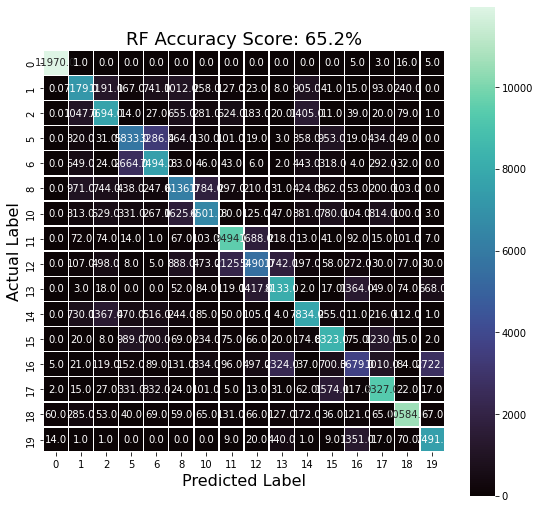

In [29]:
#Get Scores and Matrix
get_scores(rfc, X_test, y_test)

create_class_matrix(rfc, X_test, y_test)

In [26]:
#Find Feature Importance
print_importance(rfc, X)

          importance
NDVI        0.072358
B01         0.071548
B02         0.069266
NDSI        0.068430
B09         0.068152
NDWI        0.067897
B08         0.060960
B12         0.059702
B04         0.057508
B01f        0.057040
Moisture    0.054995
B06         0.052373
B11         0.052229
B05         0.047941
B8A         0.047365
B07         0.047232
B03         0.045005


## Second model with dropped features

In [6]:
#Drop 4 lowest features on importance
version10 = version10.drop(['B03', 'B07', 'B8A', 'B05'], axis = 1)

#print columns
print(version10.columns)

Index(['B01', 'B02', 'B04', 'B06', 'B08', 'B09', 'B11', 'B12', 'y', 'B01f',
       'NDVI', 'Moisture', 'NDWI', 'NDSI'],
      dtype='object')


In [7]:
#Split Data
y = version10.y
X = version10.drop('y', axis = 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [8]:
#Instantiate and Fit Model
rfc2 = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6461483233381198
Balanced Accuracy: 0.6481381844227504
F1 Score: 0.6461483233381198
Precision Score: 0.6461483233381198
Recall Score: 0.6461483233381198
ROC AUC Score: 0.9559138595102772
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12000
           1       0.62      0.60      0.61     12000
           2       0.62      0.64      0.63     12000
           5       0.50      0.48      0.49     12000
           6       0.54      0.61      0.57     12000
           8       0.52      0.50      0.51     12000
          10       0.61      0.53      0.57     12000
          11       0.71      0.78      0.74     12000
          12       0.54      0.45      0.49     12000
          13       0.62      0.68      0.65     12000
          14       0.62      0.65      0.63     12000
          15       0.62      0.68      0.65     12000
          16       0.50      0.31      0.38     12000
          17       0.67      0.77      0.72 

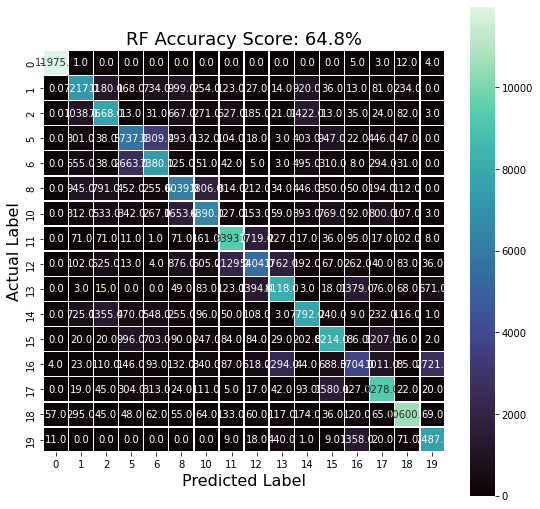

In [9]:
#Get Scores and Matrix
get_scores(rfc2, X_test, y_test)

create_class_matrix(rfc2, X_test, y_test)

In [10]:
#Find Feature Importance
print_importance(rfc2, X)

          importance
NDVI        0.087330
NDWI        0.085997
B09         0.081928
NDSI        0.081851
B02         0.080911
B06         0.079391
B12         0.075191
B11         0.074016
B01         0.073152
B01f        0.071994
B08         0.070047
B04         0.069506
Moisture    0.068688


# Model for Version 13

# Grid Search

In [ ]:
#Define grid search params
param_grid = [{'n_estimators': [100,200,300,400],
                'min_samples_leaf': [1,2,3,4],
                'max_depth': [5,6,7,8,9],
                'min_samples_split':[2,3,4]}]

#Run grid search
rfc_gs = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring = 'accuracy', cv = 5)

#Fit training data
rfc_gs.fit(X_train, y_train)